In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/BloodPressureDataset/part_4.mat
/kaggle/input/BloodPressureDataset/part_9.mat
/kaggle/input/BloodPressureDataset/part_10.mat
/kaggle/input/BloodPressureDataset/part_11.mat
/kaggle/input/BloodPressureDataset/part_3.mat
/kaggle/input/BloodPressureDataset/part_1.mat
/kaggle/input/BloodPressureDataset/part_8.mat
/kaggle/input/BloodPressureDataset/part_5.mat
/kaggle/input/BloodPressureDataset/part_6.mat
/kaggle/input/BloodPressureDataset/part_7.mat
/kaggle/input/BloodPressureDataset/part_2.mat
/kaggle/input/BloodPressureDataset/part_12.mat
/kaggle/input/BloodPressureDataset/Samples/rec_235.csv
/kaggle/input/BloodPressureDataset/Samples/rec_389.csv
/kaggle/input/BloodPressureDataset/Samples/rec_397.csv
/kaggle/input/BloodPressureDataset/Samples/rec_395.csv
/kaggle/input/BloodPressureDataset/Samples/rec_338.csv
/kaggle/input/BloodPressureDataset/Samples/rec_11.csv
/kaggle/input/BloodPressureDataset/Samples/rec_431.csv
/kaggle/input/BloodPressureDataset/Samples/rec_454.csv
/kaggl

In [3]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed, BatchNormalization, Input, ReLU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [4]:
data_path = '/kaggle/input/BloodPressureDataset'
print('Available data', os.listdir(data_path))
print('Number of files', len(os.listdir(data_path)))

Available data ['part_4.mat', 'part_9.mat', 'part_10.mat', 'Samples', 'part_11.mat', 'part_3.mat', 'part_1.mat', 'part_8.mat', 'part_5.mat', 'part_6.mat', 'part_7.mat', 'part_2.mat', 'part_12.mat']
Number of files 13


In [5]:
mat1 = sio.loadmat('/kaggle/input/BloodPressureDataset/part_1.mat')['p'][0]
mat2 = sio.loadmat('/kaggle/input/BloodPressureDataset/part_2.mat')['p'][0]
mat3 = sio.loadmat('/kaggle/input/BloodPressureDataset/part_3.mat')['p'][0]
mat4 = sio.loadmat('/kaggle/input/BloodPressureDataset/part_4.mat')['p'][0]
mat5 = sio.loadmat('/kaggle/input/BloodPressureDataset/part_5.mat')['p'][0]
mat6 = sio.loadmat('/kaggle/input/BloodPressureDataset/part_6.mat')['p'][0]
mat7 = sio.loadmat('/kaggle/input/BloodPressureDataset/part_7.mat')['p'][0]
mat8 = sio.loadmat('/kaggle/input/BloodPressureDataset/part_8.mat')['p'][0]
mat9 = sio.loadmat('/kaggle/input/BloodPressureDataset/part_9.mat')['p'][0]
mat10 = sio.loadmat('/kaggle/input/BloodPressureDataset/part_10.mat')['p'][0]
mat11 = sio.loadmat('/kaggle/input/BloodPressureDataset/part_11.mat')['p'][0]
mat12 = sio.loadmat('/kaggle/input/BloodPressureDataset/part_12.mat')['p'][0]

In [6]:
data = np.concatenate((mat1, mat2, mat3, mat4, mat5, mat6, mat7, mat8, mat9, mat10, mat11, mat12))

In [7]:
del mat1
del mat2
del mat3
del mat4
del mat5
del mat6
del mat7
del mat8
del mat9
del mat10
del mat11
del mat12

In [8]:
print(f"Total Samples: {len(data)}")

Total Samples: 12000


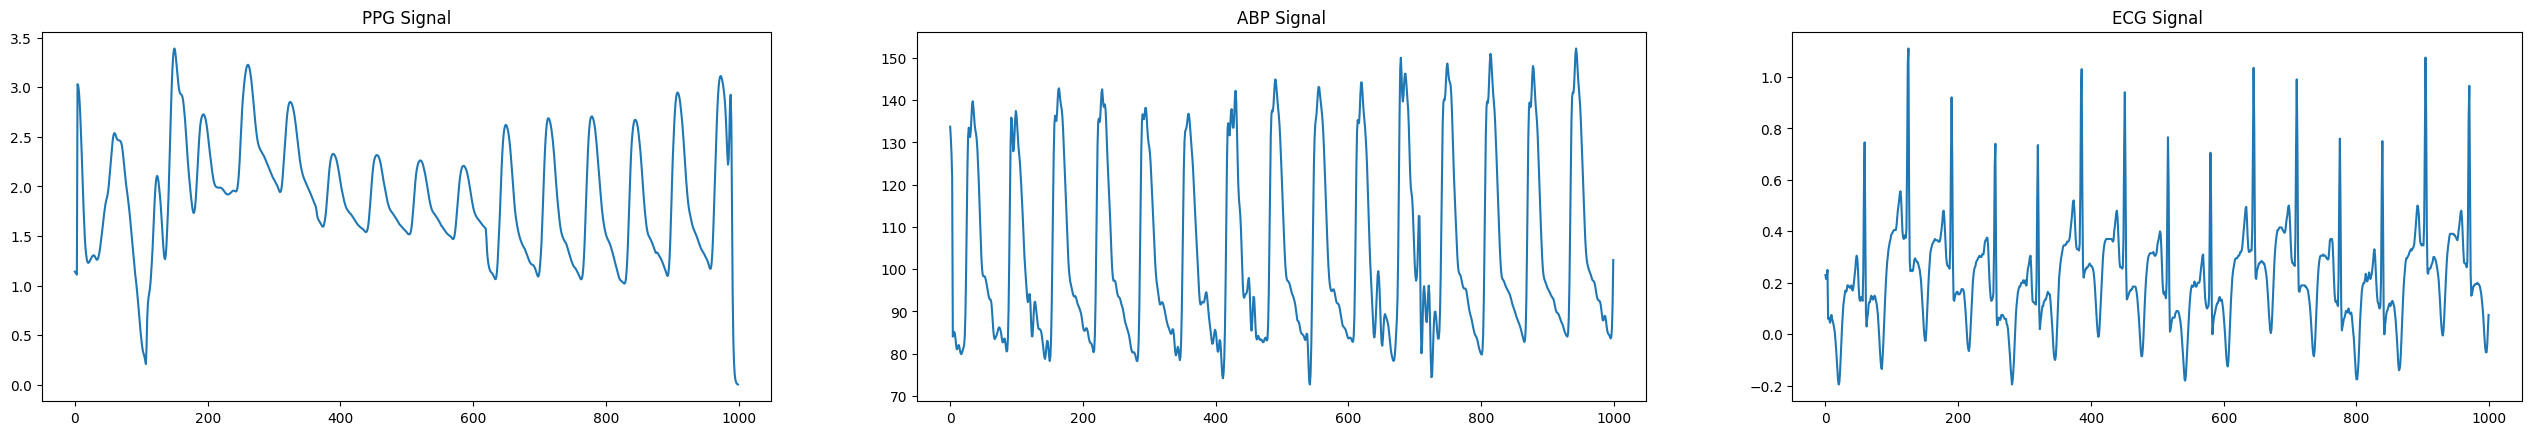

In [9]:
plt.subplot(1, 3, 1)
plt.plot(data[10][0])
plt.title('PPG Signal')

plt.subplot(1, 3, 2)
plt.plot(data[10][1])
plt.title('ABP Signal')

plt.subplot(1, 3, 3)
plt.plot(data[10][2])
plt.title('ECG Signal')

plt.subplots_adjust(right=4)

In [10]:
ppg = []
abp = []
ecg = []

for sample in data:
  ppg.append(sample[0][:250])
  abp.append(sample[1][:250])
  ecg.append(sample[2][:250])

pd.DataFrame(ppg).to_csv('/kaggle/working/ppg_250.csv', index_label=False)
pd.DataFrame(abp).to_csv('/kaggle/working/abp_250.csv', index_label=False)
pd.DataFrame(ecg).to_csv('/kaggle/working/ecg_250.csv', index_label=False)

In [11]:
ppg = pd.read_csv('/kaggle/working/ppg_250.csv')
abp = pd.read_csv('/kaggle/working/abp_250.csv')
ecg = pd.read_csv('/kaggle/working/ecg_250.csv')

In [12]:
data = np.stack((ppg, ecg), axis=-1)
X_train = data[:9600]
X_val = data[9600:10800]
X_test = data[10800:]

y_train = abp[:9600]
y_val = abp[9600:10800]
y_test = abp[10800:]

In [13]:
y_train = (y_train - 50) / 150
y_val = (y_val - 50) / 150
y_test = (y_test - 50) / 150

In [48]:
model_name = "LSTM512"

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=f'{model_name}_best.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=8,
        min_lr=1e-6,
        verbose=1
    )
]

## Dense Model 1 ##

In [20]:
dense1 = Sequential()
dense1.add(Input(shape=(250, 2)))
dense1.add(Dense(128))
dense1.add(ReLU())
dense1.add(Dropout(0.1))
dense1.add(BatchNormalization())
dense1.add(Dense(256))
dense1.add(ReLU())
dense1.add(Dropout(0.1))
dense1.add(BatchNormalization())
dense1.add(Dense(512))
dense1.add(ReLU())
dense1.add(Dropout(0.1))
dense1.add(BatchNormalization())
dense1.add(Dense(256))
dense1.add(ReLU())
dense1.add(Dropout(0.1))
dense1.add(BatchNormalization())
dense1.add(Dense(128))
dense1.add(ReLU())
dense1.add(Dropout(0.1))
dense1.add(BatchNormalization())
dense1.add(Dense(1, activation='linear'))
dense1.compile('adam', 'mse')

In [16]:
dense1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 250, 128)            │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 250, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 250, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 250, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 250, 256)            │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 250, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 250, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 250, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 250, 512)            │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 250, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 250, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 250, 512)            │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 250, 256)            │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 250, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 250, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 250, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 250, 128)            │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_4 (ReLU)                       │ (None, 250, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 250, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 334,465 (1.28 MB)

 Trainable params: 331,905 (1.27 MB)

 Non-trainable params: 2,560 (10.00 KB)

In [17]:
history_dense1 = dense1.fit(
    X_train, y_train, 
    epochs=100,                    
    batch_size=64,               
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100


I0000 00:00:1749487111.255827     106 service.cc:148] XLA service 0x7adbd0006cd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749487111.256612     106 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749487111.256631     106 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749487111.792963     106 cuda_dnn.cc:529] Loaded cuDNN version 90300


  6/150 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 2.2885

I0000 00:00:1749487116.627958     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


148/150 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6174
Epoch 1: val_loss improved from inf to 0.03525, saving model to Dense1_best.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 0.6114 - val_loss: 0.0352 - learning_rate: 0.0010
Epoch 2/100
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1220
Epoch 2: val_loss improved from 0.03525 to 0.03287, saving model to Dense1_best.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.1218 - val_loss: 0.0329 - learning_rate: 0.0010
Epoch 3/100
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0646
Epoch 3: val_loss improved from 0.03287 to 0.03273, saving model to Dense1_best.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0645 - val_loss: 0.0327 - learning_rate: 0.0010
Epoch 4/100
148/150 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0409
Epoch 4: val_loss improved from 0.03273 to 0.03132, saving model to Dense1_best.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0409 - val_loss: 0.0313 - learning_rate: 0.

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0236
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


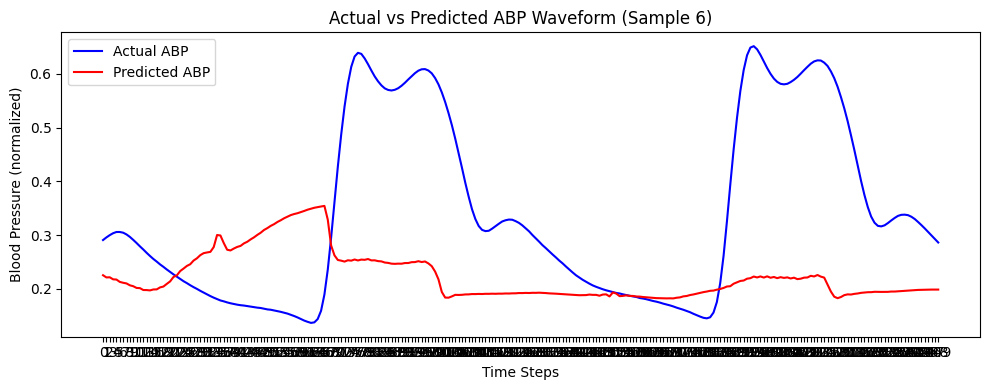

In [19]:
dense1.evaluate(X_test, y_test)

prediction_dense1 = dense1.predict(X_test)


plt.figure(figsize=(10, 4))
plt.plot(y_test.iloc[6], label='Actual ABP', color='blue')
plt.plot(prediction_dense1[6], label='Predicted ABP', color='red')
plt.title("Actual vs Predicted ABP Waveform (Sample 6)")
plt.xlabel("Time Steps")
plt.ylabel("Blood Pressure (normalized)")
plt.legend()
plt.tight_layout()
plt.show()

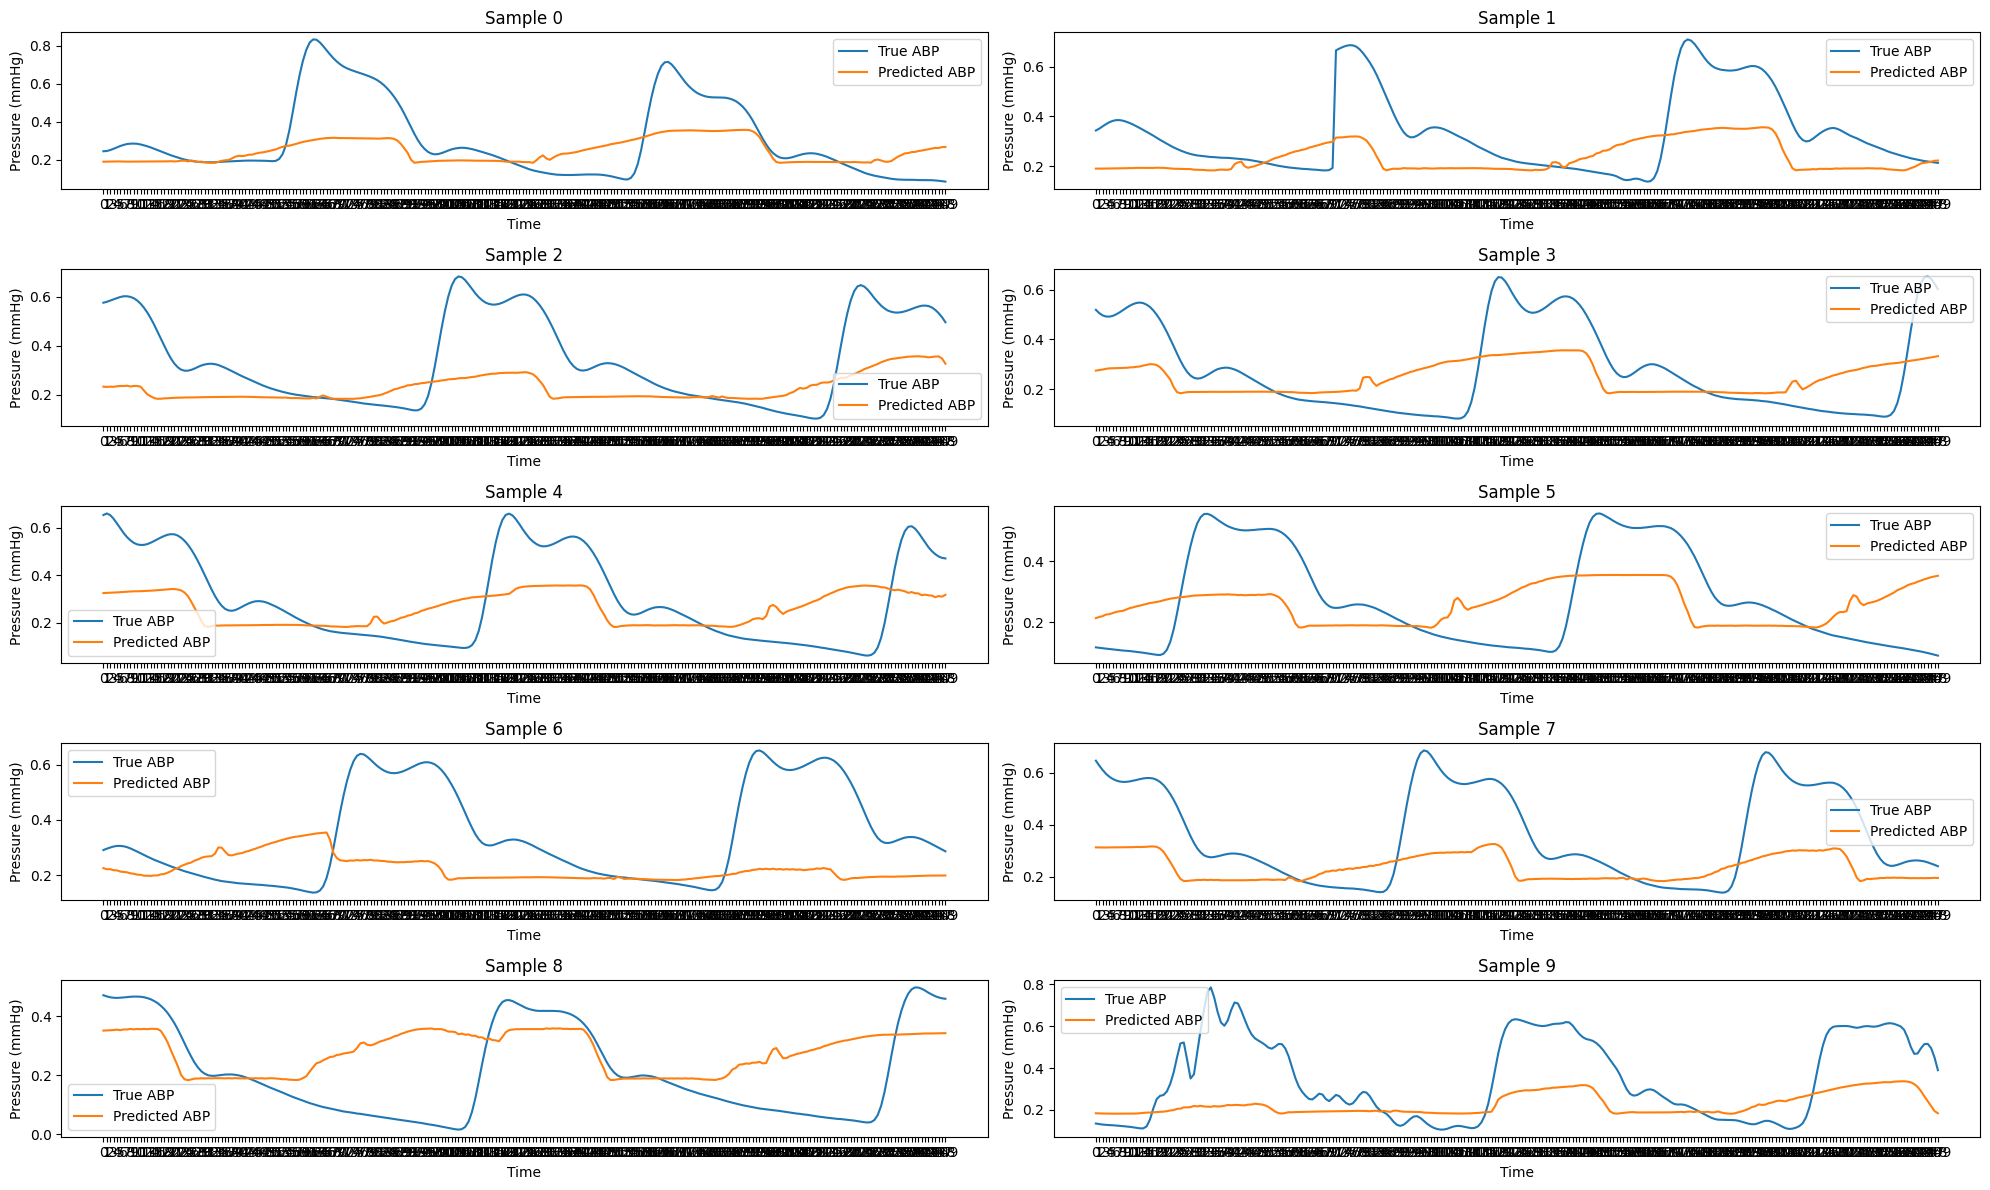

In [21]:
plt.figure(figsize=(20, 12))
for i in range(10):
    plt.subplot(5, 2, i + 1)
    plt.plot(y_test.iloc[i], label='True ABP')
    plt.plot(prediction_dense1[i], label='Predicted ABP')
    plt.title(f"Sample {i}")
    plt.xlabel("Time")
    plt.ylabel("Pressure (mmHg)")
    plt.legend()

plt.tight_layout()
plt.show()

##  LSTM 256 + Dense ##

In [22]:
inputs = Input(shape=(250, 2))
encoder = LSTM(256, return_sequences=False)(inputs)
do = Dropout(0.1)(encoder)
bn = BatchNormalization()(do)
dense_2 = Dense(250)(bn)
LSTM256_Dense = Model(inputs, dense_2)
LSTM256_Dense.compile('adam', 'mse')

In [23]:
LSTM256_Dense.summary()

Model: "functional_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 250, 2)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 256)                 │         265,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 250)                 │          64,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 330,490 (1.26 MB)

 Trainable params: 329,978 (1.26 MB)

 Non-trainable params: 512 (2.00 KB)

In [25]:
history_LSTM256_Dense = LSTM256_Dense.fit(
    X_train, y_train, 
    epochs=100,                    
    batch_size=64,               
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1407
Epoch 1: val_loss improved from inf to 0.03430, saving model to LSTM256_Dense_best.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.1402 - val_loss: 0.0343 - learning_rate: 0.0010
Epoch 2/100
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0288
Epoch 2: val_loss improved from 0.03430 to 0.03388, saving model to LSTM256_Dense_best.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0288 - val_loss: 0.0339 - learning_rate: 0.0010
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0265
Epoch 3: val_loss improved from 0.03388 to 0.03371, saving model to LSTM256_Dense_best.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0265 - val_loss: 0.0337 - learning_rate: 0.0010
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0246
Epoch 4: val_loss improved from 0.03371 to 0.03138, saving model to LSTM256_Dense_best.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0246

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0187 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


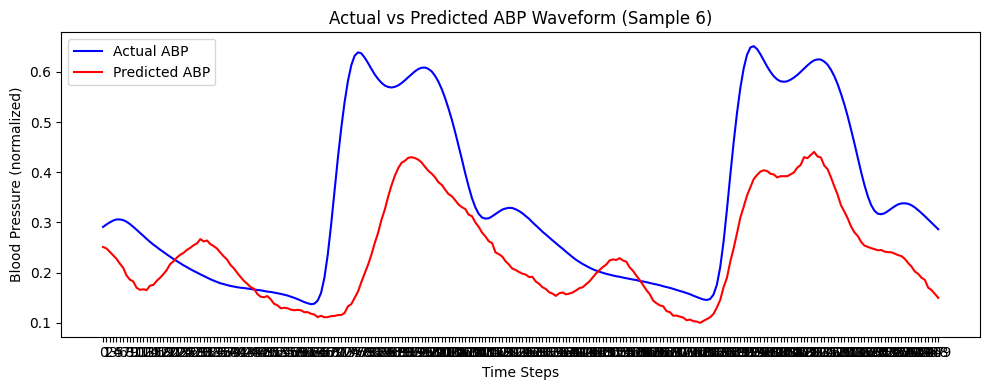

In [29]:
LSTM256_Dense.evaluate(X_test, y_test)

prediction_LSTM256_Dense = LSTM256_Dense.predict(X_test)


plt.figure(figsize=(10, 4))
plt.plot(y_test.iloc[6], label='Actual ABP', color='blue')
plt.plot(prediction_LSTM256_Dense[6], label='Predicted ABP', color='red')
plt.title("Actual vs Predicted ABP Waveform (Sample 6)")
plt.xlabel("Time Steps")
plt.ylabel("Blood Pressure (normalized)")
plt.legend()
plt.tight_layout()
plt.show()

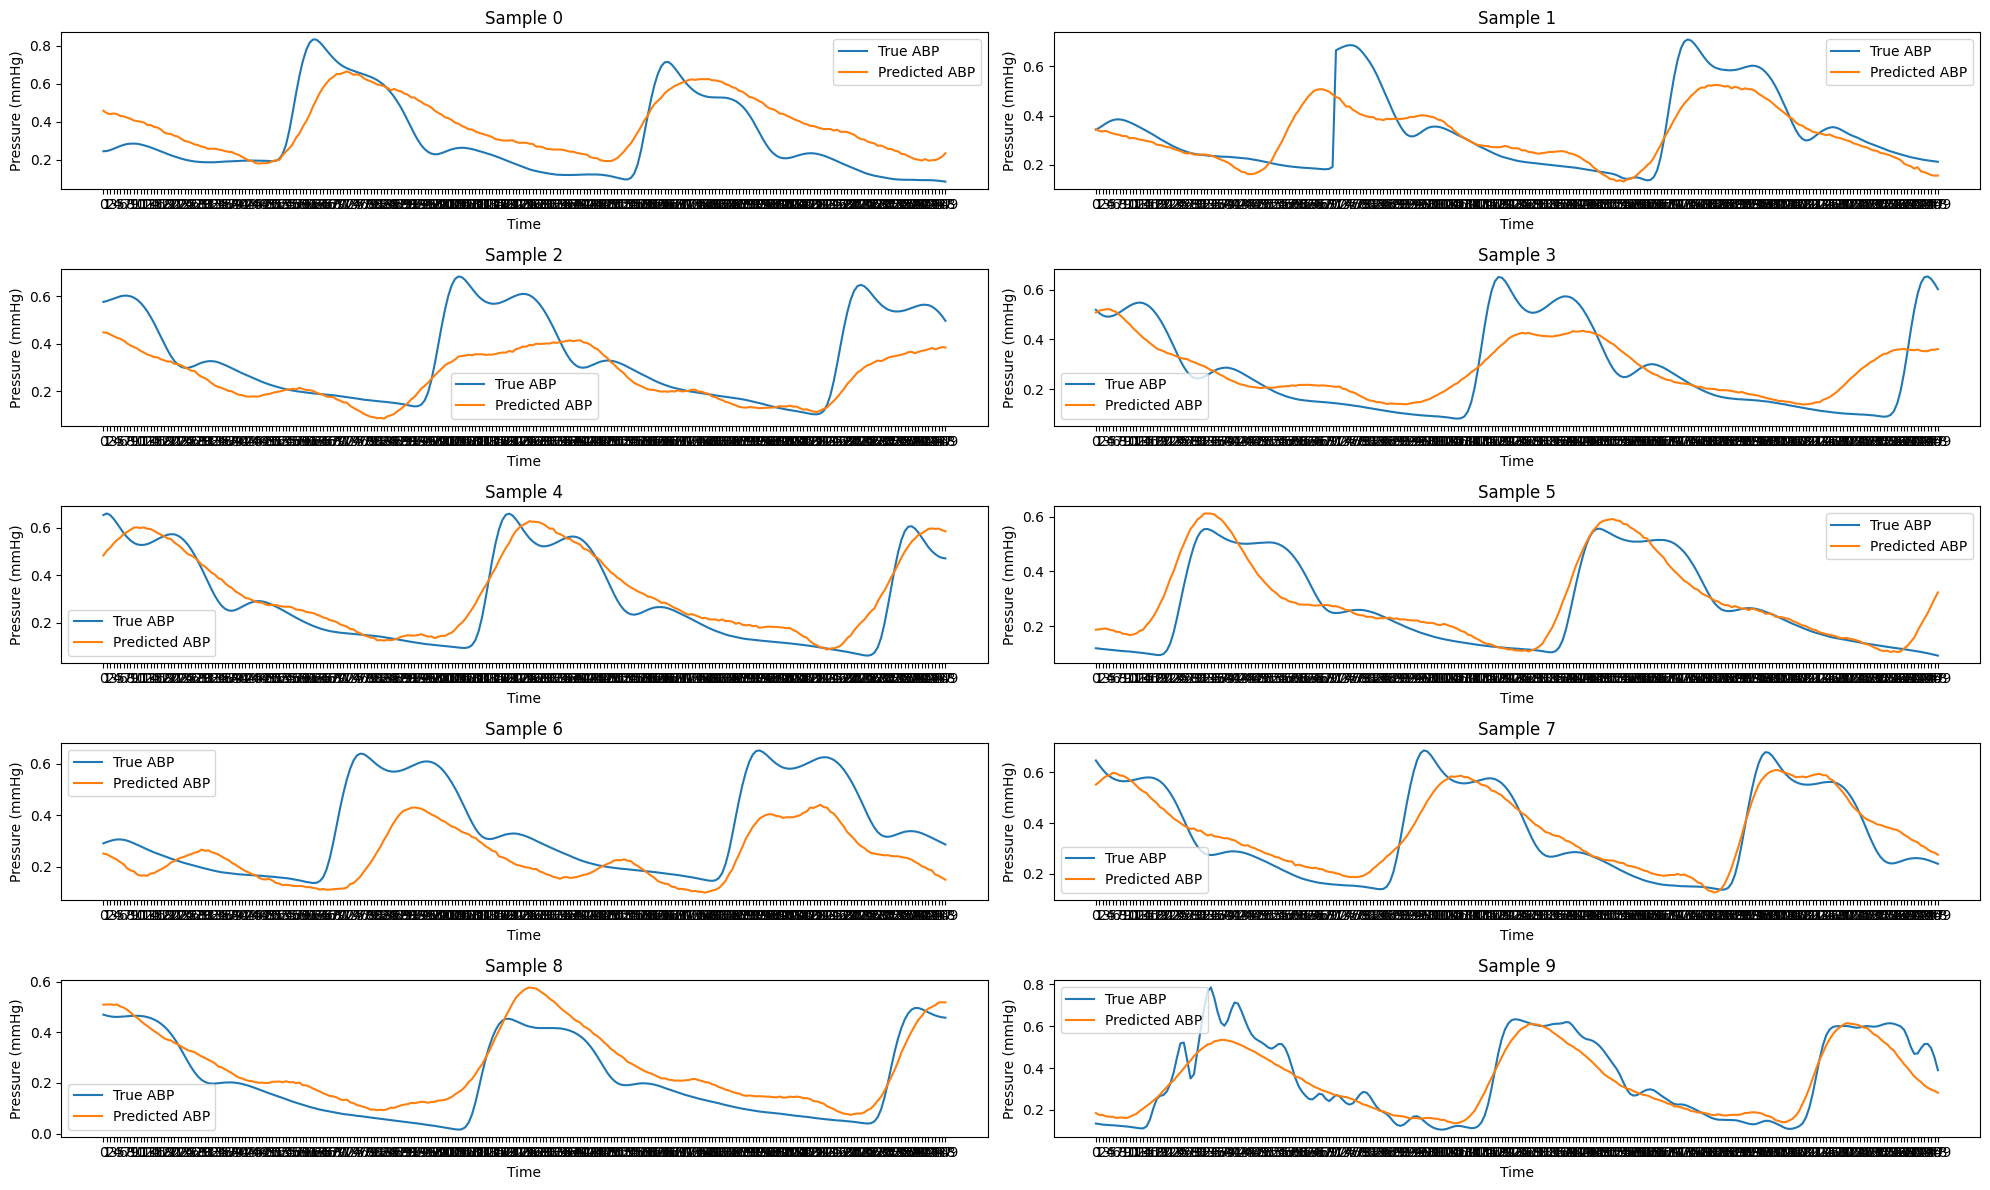

In [30]:
plt.figure(figsize=(20, 12))
for i in range(10):
    plt.subplot(5, 2, i + 1)
    plt.plot(y_test.iloc[i], label='True ABP')
    plt.plot(prediction_LSTM256_Dense[i], label='Predicted ABP')
    plt.title(f"Sample {i}")
    plt.xlabel("Time")
    plt.ylabel("Pressure (mmHg)")
    plt.legend()

plt.tight_layout()
plt.show()

##  LSTM 512 + Dense ##

In [31]:
inputs = Input(shape=(250, 2))
encoder = LSTM(512, return_sequences=False)(inputs)
do = Dropout(0.1)(encoder)
bn = BatchNormalization()(do)
dense_2 = Dense(250)(bn)
LSTM512_Dense = Model(inputs, dense_2)
LSTM512_Dense.compile('adam', 'mse')

In [32]:
LSTM512_Dense.summary()

Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 250, 2)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 512)                 │       1,054,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 250)                 │         128,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,185,018 (4.52 MB)

 Trainable params: 1,183,994 (4.52 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [34]:
history_LSTM512_Dense = LSTM512_Dense.fit(
    X_train, y_train, 
    epochs=100,                    
    batch_size=64,               
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.1091
Epoch 1: val_loss improved from inf to 0.03442, saving model to LSTM512_Dense_best.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 0.1084 - val_loss: 0.0344 - learning_rate: 0.0010
Epoch 2/100
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0276
Epoch 2: val_loss improved from 0.03442 to 0.03440, saving model to LSTM512_Dense_best.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 0.0276 - val_loss: 0.0344 - learning_rate: 0.0010
Epoch 3/100
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0265
Epoch 3: val_loss improved from 0.03440 to 0.03349, saving model to LSTM512_Dense_best.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 0.0265 - val_loss: 0.0335 - learning_rate: 0.0010
Epoch 4/100
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0255
Epoch 4: val_loss improved from 0.03349 to 0.03097, saving model to LSTM512_Dense_best.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 0.0255

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0154
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


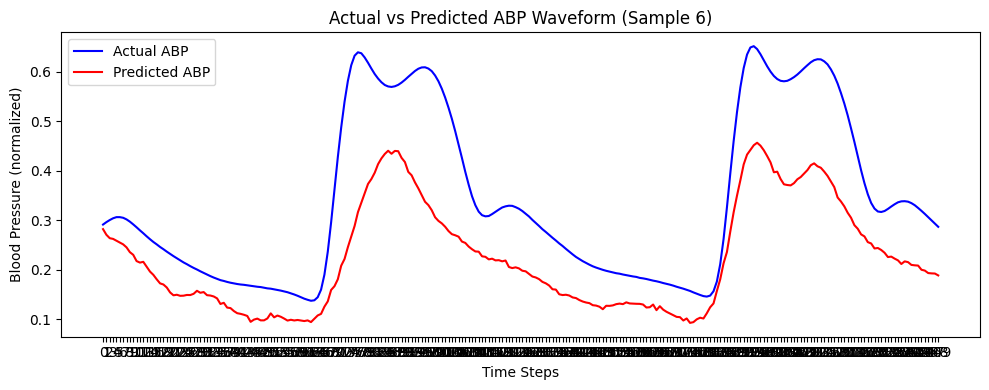

In [36]:
LSTM512_Dense.evaluate(X_test, y_test)

prediction_LSTM512_Dense = LSTM512_Dense.predict(X_test)


plt.figure(figsize=(10, 4))
plt.plot(y_test.iloc[6], label='Actual ABP', color='blue')
plt.plot(prediction_LSTM512_Dense[6], label='Predicted ABP', color='red')
plt.title("Actual vs Predicted ABP Waveform (Sample 6)")
plt.xlabel("Time Steps")
plt.ylabel("Blood Pressure (normalized)")
plt.legend()
plt.tight_layout()
plt.show()

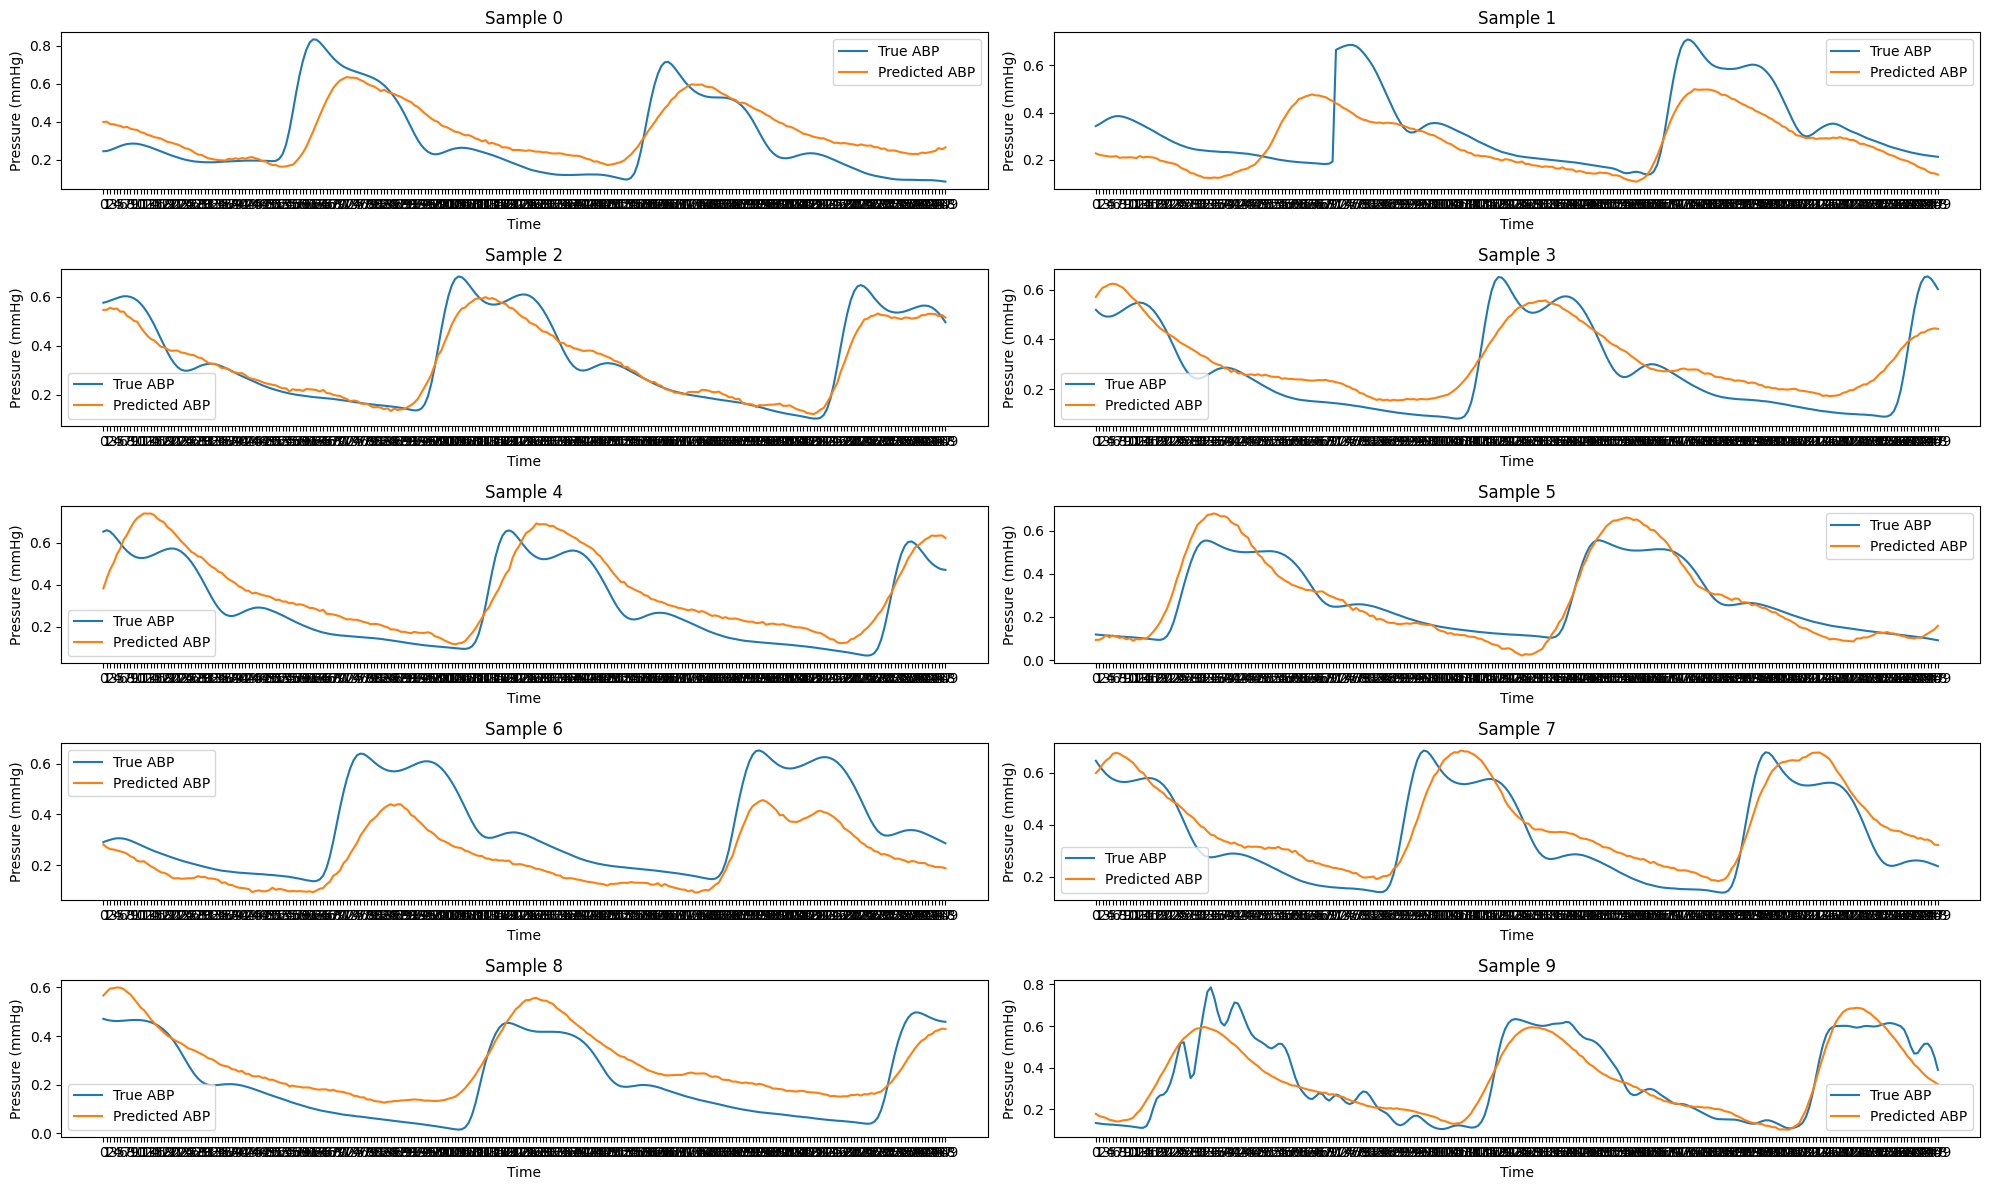

In [37]:
plt.figure(figsize=(20, 12))
for i in range(10):
    plt.subplot(5, 2, i + 1)
    plt.plot(y_test.iloc[i], label='True ABP')
    plt.plot(prediction_LSTM512_Dense[i], label='Predicted ABP')
    plt.title(f"Sample {i}")
    plt.xlabel("Time")
    plt.ylabel("Pressure (mmHg)")
    plt.legend()

plt.tight_layout()
plt.show()

## LSTM 256 UNIT ##

In [38]:
inputs = Input(shape=(250, 2))
encoder = LSTM(256, return_sequences=True)(inputs)
sequence_prediction = TimeDistributed(Dense(1, activation='linear'))(encoder)
LSTM256 = Model(inputs, sequence_prediction)
LSTM256.compile('adam', 'mse')

In [39]:
LSTM256.summary()

Model: "functional_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 250, 2)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 250, 256)            │         265,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 250, 1)              │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 265,473 (1.01 MB)

 Trainable params: 265,473 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
history_LSTM256 = LSTM256.fit(
    X_train, y_train, 
    epochs=100,                    
    batch_size=64,               
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0433
Epoch 1: val_loss improved from inf to 0.03261, saving model to LSTM256_best.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 29s 88ms/step - loss: 0.0432 - val_loss: 0.0326 - learning_rate: 0.0010
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0266
Epoch 2: val_loss improved from 0.03261 to 0.03237, saving model to LSTM256_best.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - loss: 0.0266 - val_loss: 0.0324 - learning_rate: 0.0010
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0257
Epoch 3: val_loss did not improve from 0.03237
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - loss: 0.0257 - val_loss: 0.0337 - learning_rate: 0.0010
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0251
Epoch 4: val_loss improved from 0.03237 to 0.02976, saving model to LSTM256_best.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - loss: 0.0251 - val_loss: 0.0298 - learning_rate: 0.0010
Epoch 5/100
150/

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0184
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


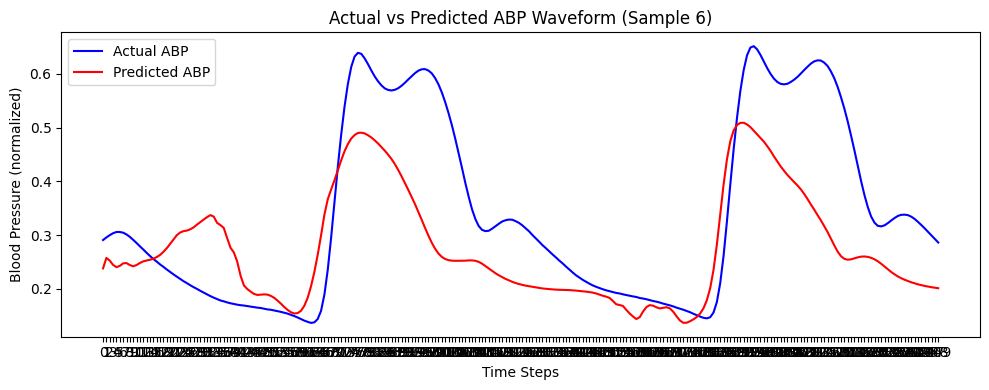

In [44]:
LSTM256.evaluate(X_test, y_test)

prediction_LSTM256 = LSTM256.predict(X_test)


plt.figure(figsize=(10, 4))
plt.plot(y_test.iloc[6], label='Actual ABP', color='blue')
plt.plot(prediction_LSTM256[6], label='Predicted ABP', color='red')
plt.title("Actual vs Predicted ABP Waveform (Sample 6)")
plt.xlabel("Time Steps")
plt.ylabel("Blood Pressure (normalized)")
plt.legend()
plt.tight_layout()
plt.show()

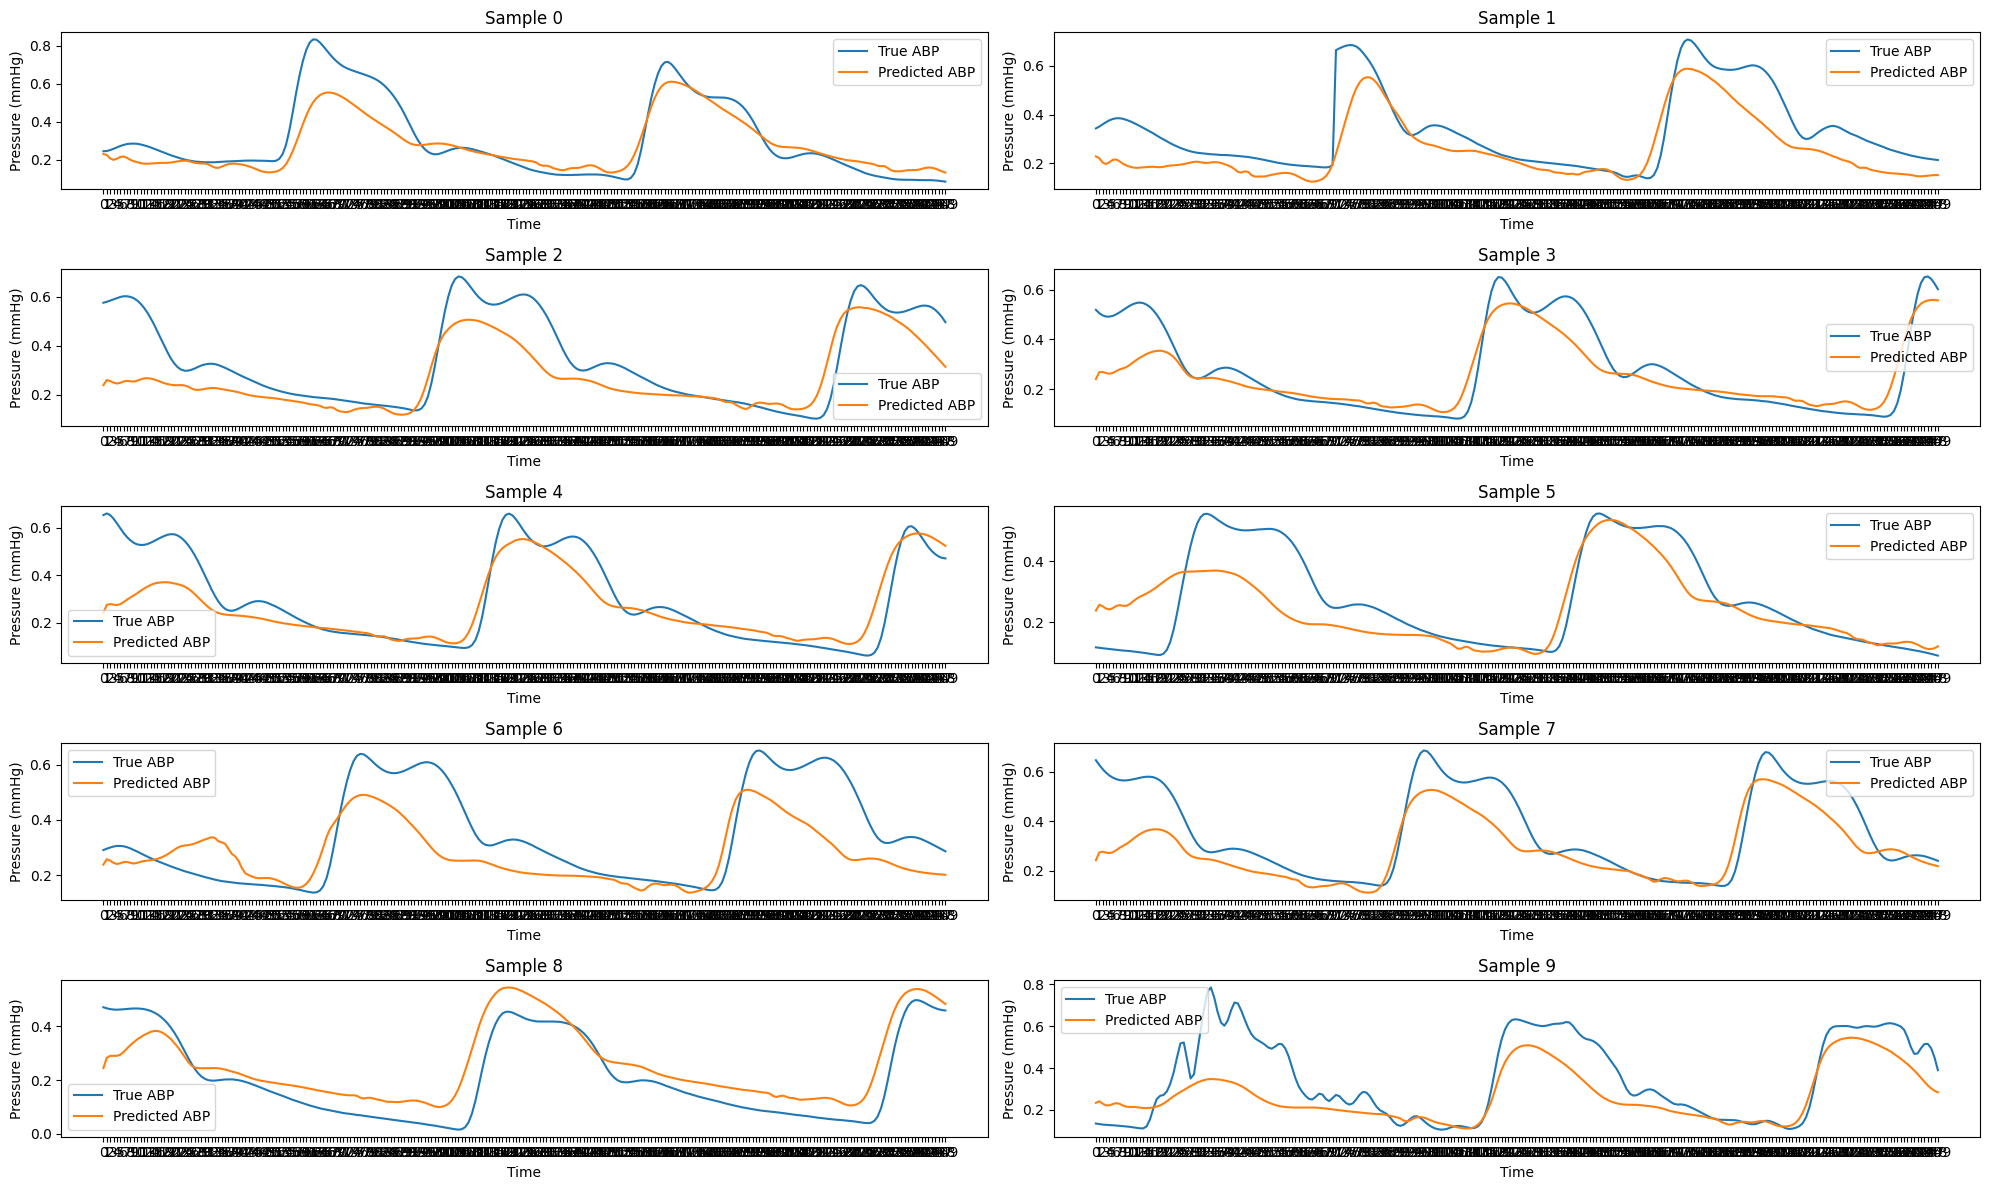

In [45]:
plt.figure(figsize=(20, 12))
for i in range(10):
    plt.subplot(5, 2, i + 1)
    plt.plot(y_test.iloc[i], label='True ABP')
    plt.plot(prediction_LSTM256[i], label='Predicted ABP')
    plt.title(f"Sample {i}")
    plt.xlabel("Time")
    plt.ylabel("Pressure (mmHg)")
    plt.legend()

plt.tight_layout()
plt.show()

## LSTM 512 UNIT ##

In [46]:
inputs = Input(shape=(250, 2))
encoder = LSTM(512, return_sequences=True)(inputs)
sequence_prediction = TimeDistributed(Dense(1, activation='linear'))(encoder)
LSTM512 = Model(inputs, sequence_prediction)
LSTM512.compile('adam', 'mse')

In [47]:
LSTM512.summary()

Model: "functional_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 250, 2)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 250, 512)            │       1,054,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 250, 1)              │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,055,233 (4.03 MB)

 Trainable params: 1,055,233 (4.03 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
history_LSTM512 = LSTM512.fit(
    X_train, y_train, 
    epochs=100,                    
    batch_size=64,               
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0496
Epoch 1: val_loss improved from inf to 0.03277, saving model to LSTM512_best.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 153ms/step - loss: 0.0495 - val_loss: 0.0328 - learning_rate: 0.0010
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.0262
Epoch 2: val_loss improved from 0.03277 to 0.03095, saving model to LSTM512_best.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 132ms/step - loss: 0.0262 - val_loss: 0.0310 - learning_rate: 0.0010
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.0256
Epoch 3: val_loss did not improve from 0.03095
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 132ms/step - loss: 0.0256 - val_loss: 0.0316 - learning_rate: 0.0010
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.0176
Epoch 6: val_loss improved from 0.02274 to 0.02070, saving model to LSTM512_best.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - loss: 0.0176 - val_loss: 0.0207 - learning_rate: 0.0010
Epoch 7/

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0178
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


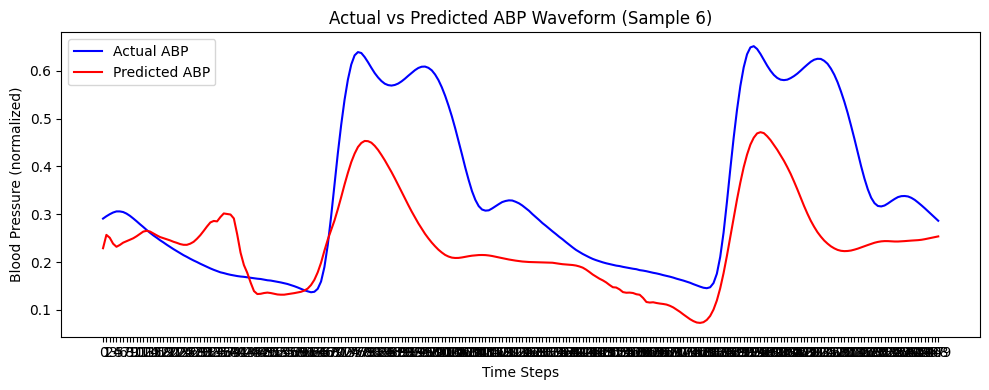

In [52]:
LSTM512.evaluate(X_test, y_test)

prediction_LSTM512 = LSTM512.predict(X_test)


plt.figure(figsize=(10, 4))
plt.plot(y_test.iloc[6], label='Actual ABP', color='blue')
plt.plot(prediction_LSTM512[6], label='Predicted ABP', color='red')
plt.title("Actual vs Predicted ABP Waveform (Sample 6)")
plt.xlabel("Time Steps")
plt.ylabel("Blood Pressure (normalized)")
plt.legend()
plt.tight_layout()
plt.show()

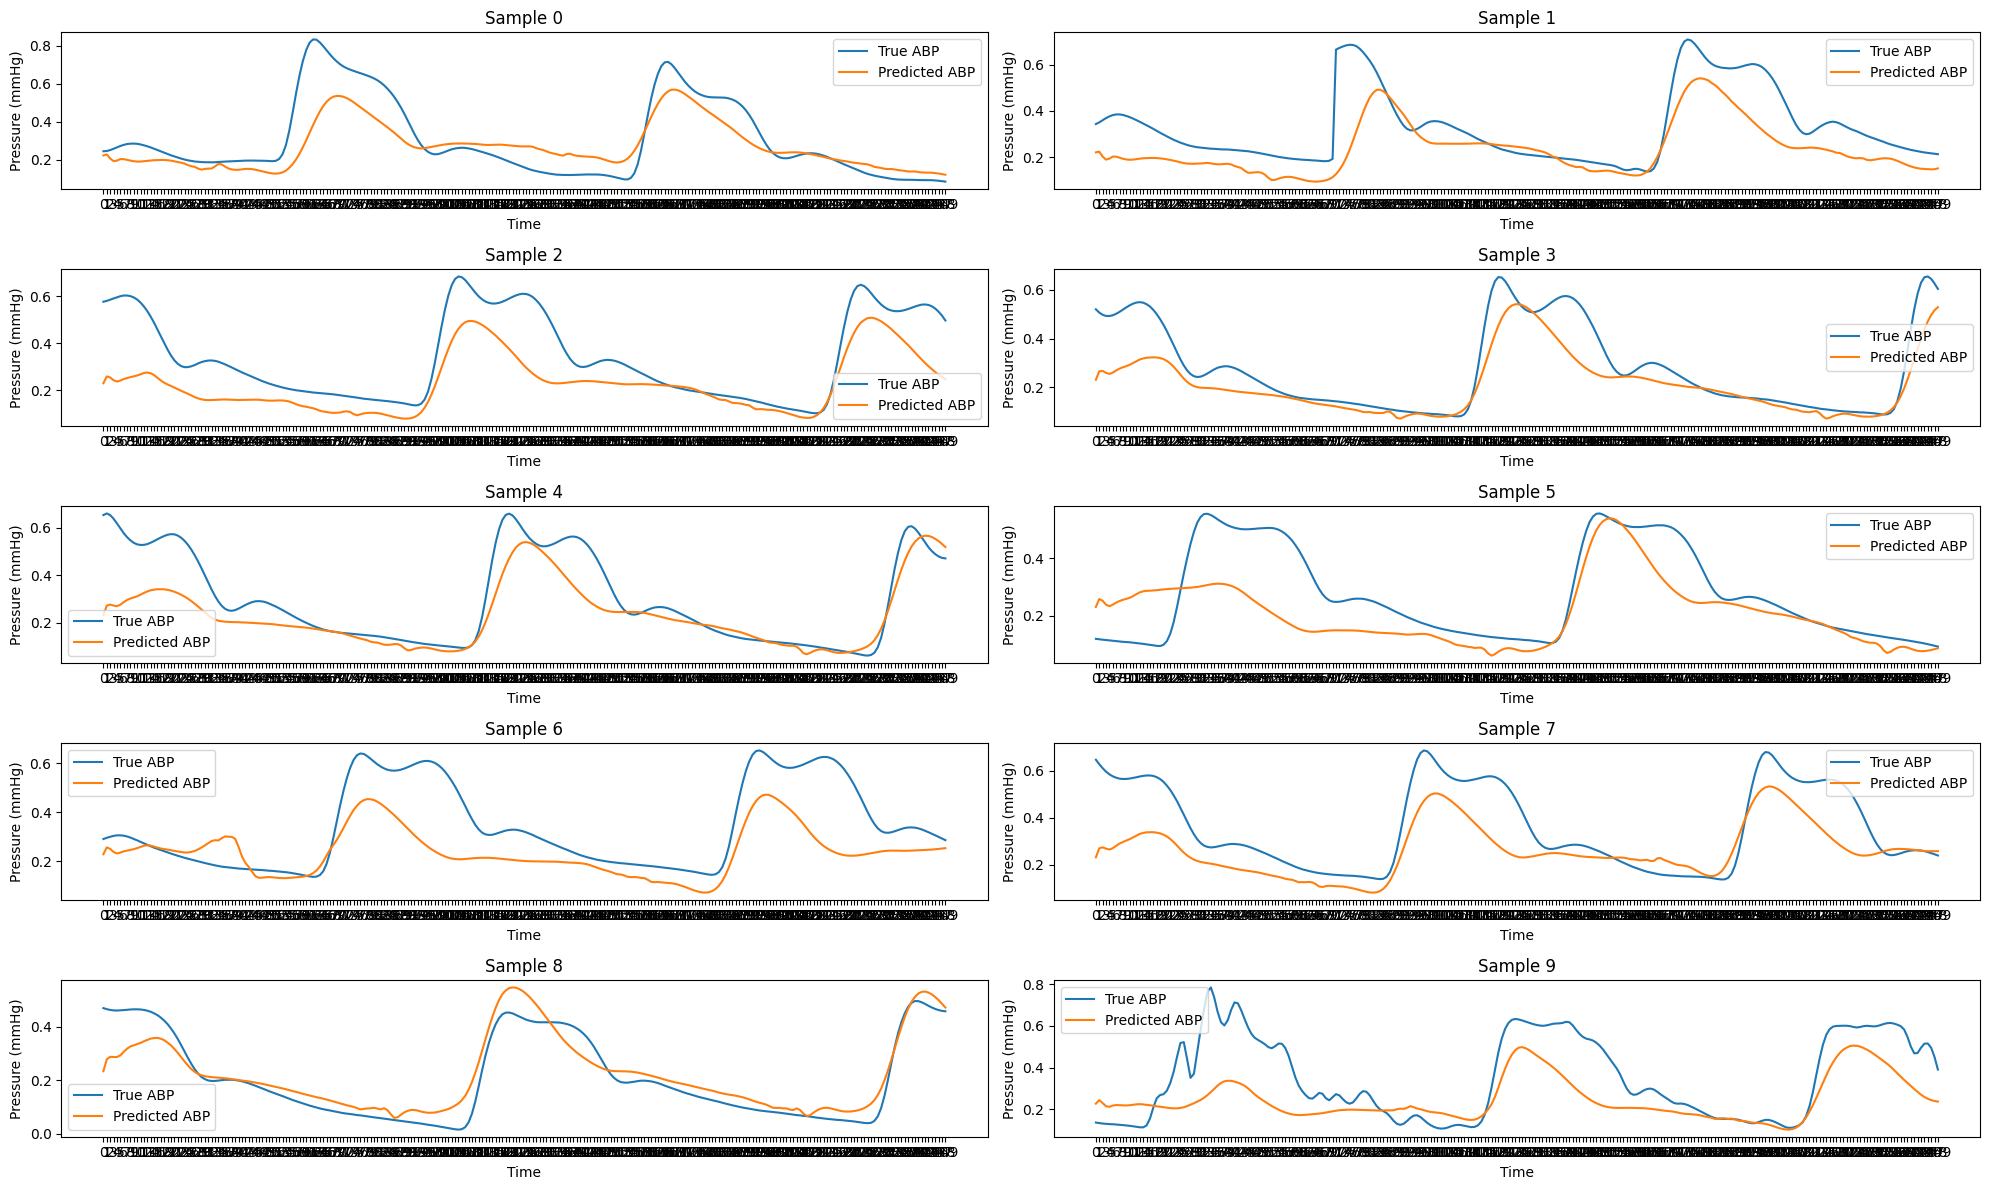

In [53]:
# Plotting 10 predictions vs. actual ABP waveforms
plt.figure(figsize=(20, 12))
for i in range(10):
    plt.subplot(5, 2, i + 1)
    plt.plot(y_test.iloc[i], label='True ABP')
    plt.plot(prediction_LSTM512[i], label='Predicted ABP')
    plt.title(f"Sample {i}")
    plt.xlabel("Time")
    plt.ylabel("Pressure (mmHg)")
    plt.legend()

plt.tight_layout()
plt.show()